<a href="https://colab.research.google.com/github/whykusanagi/vThree_Sizes/blob/main/Vtuber_3_Sizes_Estimator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# vThree_Sizes Character Measurement Calculation
Calculator for vtubers to determine their 3 sizes accurately.
This notebook processes an anime character image to extract height, bust, waist, underbust, and hip measurements using Mediapipe Pose.

### Conversion Explanation
- The reference character height is set to **175 cm**. As my character is tall and based on the male vtuber model she is derived from.
- The **Nude** height in pixels (1410 pixels) is used as the baseline for conversion.
- The **cm/pixel ratio** is calculated as:
  
  \[
  cm\_per\_pixel = \frac{175}{1410} \approx 0.1241 \text{ cm/pixel}
  \]

You can change the calculation as needed, but if your character is smaller you can adjust the parameter to the average height.
The average American woman is approximately 5 feet 4 inches (162.5 cm) according to the CDC.

### Cup Size Calculation
- Cup size is determined by the difference between the bust and underbust measurements, following standard thresholds:
  - **AA**: 1.0-2.5 cm
  - **A**: 2.6-3.5 cm
  - **B**: 3.6-5.0 cm
  - **C**: 5.1-6.5 cm
  - **D**: 6.6-8.0 cm
  - **DD/E**: 8.1-9.5 cm
  - **F**: 9.6-11.0 cm
  - **G**: 11.1-12.5 cm
  - **H**: 12.6-14.0 cm

### Output Data Table
The final table provides measurements in centimeters for each outfit variation, including the estimated cup size.


If you found this tool helpful, donate so I can spend more time building random projects like this for the community.
![Donate](https://s3.whykusanagi.xyz/Simple_Header_Image.png)(https://streamelements.com/whykusanagi/tip)

In [ ]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 44.0 MB/s eta 0:00:00


In [ ]:
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
import pandas as pd

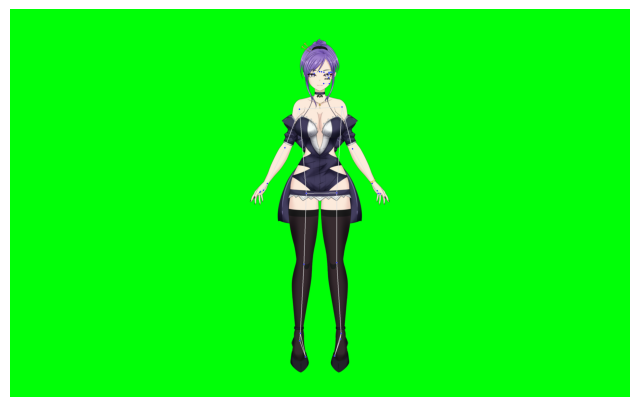

          Height  Bust  Waist  Underbust   Hip Cup Size
Bunny      179.8  32.4   22.3       21.7  22.3        F
Marie      175.0  29.2   20.9       20.2  20.9     DD/E
No Dress   137.4  31.5   21.0       20.4  21.0        G
Nude       175.0  30.7   21.0       20.4  21.0        F
PlugSuit   177.9  29.9   22.0       21.3  22.0     DD/E


In [ ]:
# Load the image
image_path = "/content/marie_dress.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Initialize Mediapipe Pose
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose = mp_pose.Pose(static_image_mode=True, model_complexity=2)

# Process the image
results = pose.process(image)

# Draw keypoints on the image
if results.pose_landmarks:
    annotated_image = image.copy()
    mp_drawing.draw_landmarks(
        annotated_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
else:
    annotated_image = image.copy()
    print("No pose detected.")

# Display the annotated image
plt.figure(figsize=(8, 10))
plt.imshow(annotated_image)
plt.axis("off")
plt.show()

# Conversion factor
reference_height_cm = 175  # cm
reference_height_pixels = 1410  # pixels from Nude measurements
cm_per_pixel = reference_height_cm / reference_height_pixels

# Updated measurements in pixels
measurements = {
    "Bunny": {"Height": 1449, "Bust": 261, "Waist": 180, "Underbust": 175, "Hip": 180},
    "Marie": {"Height": 1410, "Bust": 235, "Waist": 168, "Underbust": 163, "Hip": 168},
    "No Dress": {"Height": 1107, "Bust": 254, "Waist": 169, "Underbust": 164, "Hip": 169},
    "Nude": {"Height": 1410, "Bust": 247, "Waist": 169, "Underbust": 164, "Hip": 169},
    "PlugSuit": {"Height": 1433, "Bust": 241, "Waist": 177, "Underbust": 172, "Hip": 177},
}

# Convert pixels to cm
converted_measurements = {}
for outfit, data in measurements.items():
    converted_measurements[outfit] = {key: round(value * cm_per_pixel, 1) for key, value in data.items()}

# Refine cup size calculation
def refine_estimate_cup_size(bust, underbust):
    bust_difference = bust - underbust

    # Updated cup size conversion based on bust difference (standard thresholds)
    refined_cup_sizes = {
        (1.0, 2.5): "AA",
        (2.6, 3.5): "A",
        (3.6, 5.0): "B",
        (5.1, 6.5): "C",
        (6.6, 8.0): "D",
        (8.1, 9.5): "DD/E",
        (9.6, 11.0): "F",
        (11.1, 12.5): "G",
        (12.6, 14.0): "H"
    }

    # Determine cup size based on bust difference
    for (lower, upper), size in refined_cup_sizes.items():
        if lower <= bust_difference <= upper:
            return size
    return "Unknown"

# Calculate cup sizes
refined_cup_sizes = {}
for outfit, data in converted_measurements.items():
    bust = data["Bust"]
    underbust = data["Underbust"]
    refined_cup_sizes[outfit] = refine_estimate_cup_size(bust, underbust)

# Add cup sizes to the final dataframe
df = pd.DataFrame.from_dict(converted_measurements, orient="index")
df["Cup Size"] = pd.Series(refined_cup_sizes)

# Display the updated dataframe
print(df)

Bunny Measurements:
```
Height (pixels): 1449 pixels
Bust (pixels): 261 pixels
Waist (pixels): 180 pixels
Underbust (pixels): 175 pixels
Hip (pixels): 180 pixels
```

Marie Measurements:
```
Height (pixels): 1410 pixels
Bust (pixels): 235 pixels
Waist (pixels): 168 pixels
Underbust (pixels): 163 pixels
Hip (pixels): 168 pixels
```

No Dress Measurements:
```
Height (pixels): 1107 pixels
Bust (pixels): 254 pixels
Waist (pixels): 169 pixels
Underbust (pixels): 164 pixels
Hip (pixels): 169 pixels
```

Nude Measurements:
```
Height (pixels): 1410 pixels
Bust (pixels): 247 pixels
Waist (pixels): 169 pixels
Underbust (pixels): 164 pixels
Hip (pixels): 169 pixels
```

PlugSuit Measurements:
```
Height (pixels): 1433 pixels
Bust (pixels): 241 pixels
Waist (pixels): 177 pixels
Underbust (pixels): 172 pixels
Hip (pixels): 177 pixels
```